In [687]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm


import sklearn.preprocessing as pre
from sklearn import model_selection
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.kernel_ridge import KernelRidge
from sklearn import ensemble
from sklearn.compose import TransformedTargetRegressor
from sklearn.svm import SVC

In [575]:
##Let's read in the data. 

data = pd.read_csv("/Users/milesklingenberg/Documents/UWMSBA/590/Data/train_house-1.csv", dtype=CAT_DTYPES)

In [576]:
#We also need to read in and clean the test

In [577]:
test = pd.read_csv("/Users/milesklingenberg/Documents/UWMSBA/590/Data/test.csv", dtype=CAT_DTYPES)

In [578]:
data.head(10)
##Let's take a look at the data. 

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0000000000,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0000000000,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0000000000,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0000000000,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0000000000,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0000000000,14115,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0000000000,10084,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,8,60,RL,nan,10382,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0000000000,6120,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0000000000,7420,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2008,WD,Normal,118000


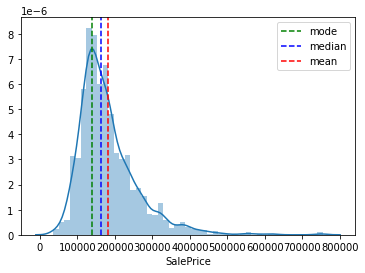

In [579]:
sigma = data.SalePrice.std()
mu = data.SalePrice.mean()
med = data.SalePrice.median()
mode = data.SalePrice.mode().to_numpy()

sns.distplot(data.SalePrice)
plt.axvline(mode, linestyle='--', color='green', label='mode')
plt.axvline(med, linestyle='--', color='blue', label='median')
plt.axvline(mu, linestyle='--', color='red', label='mean')
plt.legend()

#here we are just looking at the distribution of the data. 

In [580]:
#Goods news is the data nearly normal distributed. 

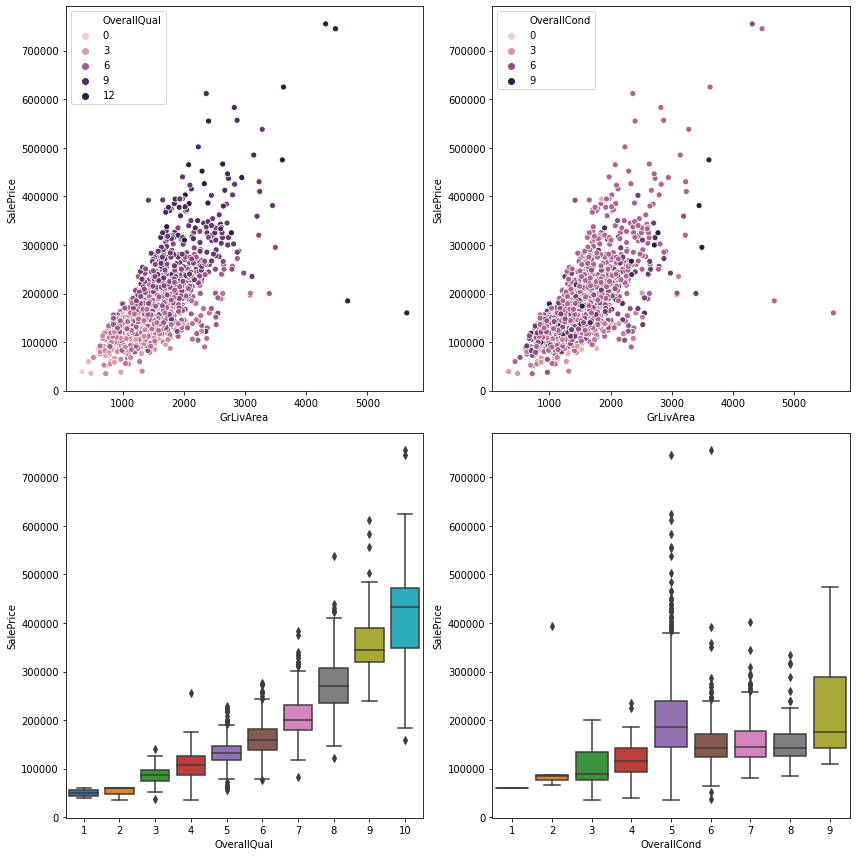

In [581]:
fig, axes = plt.subplots(2,2, figsize=(12,12))
sns.scatterplot(x='GrLivArea', y='SalePrice', hue='OverallQual', data=data, ax=axes[0,0])
sns.scatterplot(x='GrLivArea', y='SalePrice', hue='OverallCond', data=data, ax=axes[0,1])
sns.boxplot(x='OverallQual', y='SalePrice', data=data, ax=axes[1,0])
sns.boxplot(x='OverallCond', y='SalePrice', data=data, ax=axes[1,1])
plt.tight_layout()

##In these graphs we are looking at Sale Price compared to sf of general living area. 
##We are using overall quality for hue. 
##In the boxplots we are looking at the Sale price and the distribution by Overall Condition.

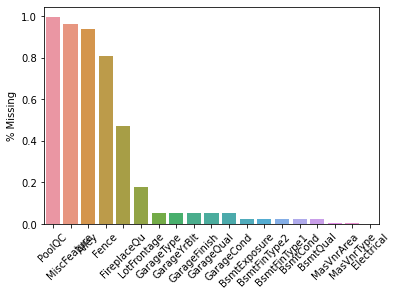

In [582]:
##This is a function for looking at the missing data. 

def viz_missing(df):

    missing = pd.DataFrame({
        'Missing':df.isnull().sum(),
        '% Missing': df.isnull().sum()/len(df)
    })
    missing = missing[missing['% Missing'] > 0].sort_values(by='Missing', ascending=False)
    sns.barplot(x=missing.index, y='% Missing', data=missing)
    plt.xticks(rotation=45)
    plt.show()

viz_missing(data)

In [583]:
#Let's look at missing data. 
#We can see that pool qc, fireplace and misc features are some of the highest null values. 

In [584]:
#If we combine, we can see that when Fireplace ==0 and Fireplace is null, it is actually the case 
# of a home not having a fireplace, and such fireplaceQu should be na, not nan.
nofire_na = data.loc[data.FireplaceQu.isna() &
                         (data.Fireplaces == 0)].shape[0]
data.FireplaceQu.isna().sum(), nofire_na


(690, 690)

In [585]:
data['FireplaceQu'] = data['FireplaceQu'].cat.add_categories('NA')
data.FireplaceQu.fillna('NA', inplace=True)

In [586]:
#we can check if it is also the case for pool qc as well 

In [587]:
pool_na = data.loc[data.PoolQC.isna() & (data.PoolArea == 0)].shape[0]
pool_na, data.PoolQC.isna().sum()

(1453, 1453)

In [588]:
data['PoolQC'] = data['PoolQC'].cat.add_categories('NA')
data.PoolQC.fillna('NA', inplace=True)

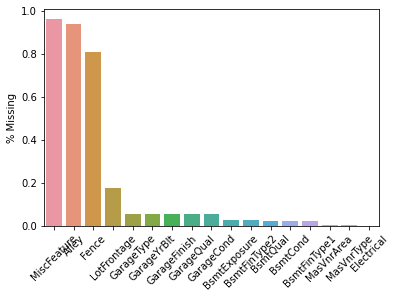

In [589]:
#since we have filled in some of our data, let's take a look again. 
viz_missing(data)

In [590]:
#So you can see that we have definitely gotten rid of some of the missing data pretty easily. 
#Misc Features is tough, so we will move to alley and fence, and replace with median for tolerance to 
#outliers. 

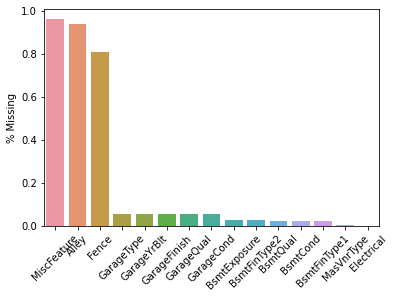

In [591]:
data.MasVnrArea.fillna(data.MasVnrArea.median(), inplace=True)
data.LotFrontage.fillna(data.LotFrontage.median(), inplace=True)
viz_missing(data)

In [592]:
for var in ['GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond']:
    print(data[var].isna().sum())

81
81
81
81
81


In [593]:
data['GarageFinish'] = data['GarageFinish'].cat.add_categories('NA')
data['GarageQual'] = data['GarageQual'].cat.add_categories('NA')
data['GarageCond'] = data['GarageCond'].cat.add_categories('NA')

In [594]:
data['GarageType'] = data['GarageType'].cat.add_categories('NA')

In [595]:
for var in ['GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond']:
    data[var].fillna('NA', inplace=True)

In [596]:
#So, for all of the garage variables we have the exact same amoutn of missing variables, which probably means 
#these are homes without garages. We can also check with basement. 

In [597]:
for var in ['BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtQual', 'BsmtCond']:
    print(data[var].isnull().sum())

38
37
38
37
37


In [598]:
#Not quite the same. But, we will fill this in with NA as well. 

In [599]:
data['BsmtExposure'] = data['BsmtExposure'].cat.add_categories('NA')
data['BsmtFinType1'] = data['BsmtFinType1'].cat.add_categories('NA')
data['BsmtFinType2'] = data['BsmtFinType2'].cat.add_categories('NA')
data['BsmtQual'] = data['BsmtQual'].cat.add_categories('NA')
data['BsmtCond'] = data['BsmtCond'].cat.add_categories('NA')

for var in ['BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtQual', 'BsmtCond']:
    data[var].fillna('NA', inplace=True)

In [600]:
data[['BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtQual', 'BsmtCond']].isna().sum()

BsmtExposure    0
BsmtFinType1    0
BsmtFinType2    0
BsmtQual        0
BsmtCond        0
dtype: int64

In [601]:
##forgot to fill miscfeature
data['MiscFeature'] = data['MiscFeature'].cat.add_categories('NA')
data.MiscFeature.fillna('NA', inplace=True)

In [602]:
#Alley and Fence I am going to drop. 

In [603]:
data.loc[data.GarageYrBlt.isna(), 'GarageYrBlt'] = data.YearBuilt
data.MasVnrType.fillna('None', inplace=True) # fill with mode

In [604]:
data['Electrical'] = data['Electrical'].cat.add_categories('Sbrkr')
data.Electrical.fillna('Sbrkr', inplace=True)

In [605]:
data = data.drop(['Alley', 'Fence'], axis=1)

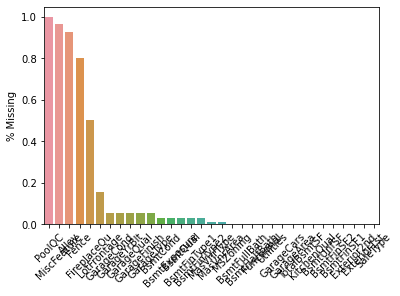

In [606]:
viz_missing(test)

In [607]:
#So, we also need to look at the test data and see if the missing values are consistent with 
#the same missing data in the train data. If the feature does not exist we will insert an NA. 

In [608]:
test['PoolQC'] = test['PoolQC'].cat.add_categories('NA')

In [609]:
m = test.PoolQC.mode()[0]

test.loc[test.PoolQC.isna() & (test.PoolArea > 0), 'PoolQC'] = m

test.loc[test.PoolQC.isna() & (test.PoolArea == 0), ['PoolQC']] = 'NA'

In [610]:
test['MiscFeature'] = test['MiscFeature'].cat.add_categories('NA')
test['FireplaceQu'] = test['FireplaceQu'].cat.add_categories('NA')

In [611]:
test.MiscFeature.fillna('NA', inplace=True)
test.FireplaceQu.fillna('NA', inplace=True)
test.MasVnrArea.fillna(test.MasVnrArea.median(), inplace=True)
test.LotFrontage.fillna(test.LotFrontage.median(), inplace=True)


In [612]:
# Drop these two columns, just as we did for the training data.
test.drop(['Alley', 'Fence'], axis=1, inplace=True)

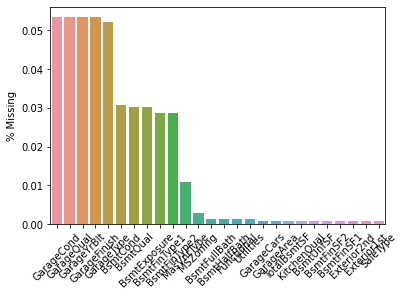

In [613]:
viz_missing(test)

In [614]:
garage_vals = ['GarageCond', 'GarageQual', 'GarageFinish', 'GarageType']
test.loc[test.GarageArea.isna(), garage_vals]

,GarageCond,GarageQual,GarageFinish,GarageType
1116,NaN,NaN,NaN,Detchd


In [615]:
g_type = garage_vals.pop(3)

for g in garage_vals:
    mode = test[g].mode()[0]
    test.loc[test.GarageArea.isna(), g] = mode

med = test.GarageArea.median()
test.loc[test.GarageArea.isna(), 'GarageArea']  = med

garage_vals.append(g_type)    

test.loc[test.GarageArea.isna(), garage_vals]

,GarageCond,GarageQual,GarageFinish,GarageType


In [616]:
test['GarageQual'] = test['GarageQual'].cat.add_categories('NA')
test['GarageFinish'] = test['GarageFinish'].cat.add_categories('NA')
test['GarageType'] = test['GarageType'].cat.add_categories('NA')
test['GarageCond'] = test['GarageCond'].cat.add_categories('NA')


for g in garage_vals:
    
    mode = test[g].mode()[0]
    test.loc[test[g].isna() & (test.GarageArea > 0), g] = mode
    test.loc[test[g].isna() & (test.GarageArea == 0), g] = 'NA'

In [617]:
years = test.loc[test.GarageYrBlt.isna(), 'YearBuilt']
test.loc[test.GarageYrBlt.isna(), 'GarageYrBlt'] = years

In [618]:
bsmt_vars = ['BsmtCond', 'BsmtQual', 'BsmtExposure', 'BsmtFinType1']
bsmt_sf = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF']
test.loc[test.TotalBsmtSF.isna(), bsmt_vars+bsmt_sf]

,BsmtCond,BsmtQual,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF
660,NaN,NaN,NaN,NaN,nan,nan,nan,nan


In [619]:
test.loc[test.TotalBsmtSF.isna(), bsmt_sf] = 0

In [620]:
test.loc[:, bsmt_sf].isna().sum()

BsmtFinSF1     0
BsmtFinSF2     0
BsmtUnfSF      0
TotalBsmtSF    0
dtype: int64

In [621]:
test['BsmtExposure'] = test['BsmtExposure'].cat.add_categories('NA')
test['BsmtFinType1'] = test['BsmtFinType1'].cat.add_categories('NA')
test['BsmtFinType2'] = test['BsmtFinType2'].cat.add_categories('NA')
test['BsmtQual'] = test['BsmtQual'].cat.add_categories('NA')
test['BsmtCond'] = test['BsmtCond'].cat.add_categories('NA')

for var in bsmt_vars:
    mode = test[var].mode()[0]
    test.loc[test[var].isnull() & (test.TotalBsmtSF == 0), var] = 'NA'
    test.loc[test[var].isnull() & (test.TotalBsmtSF > 0), var] = mode

    
finish = test.loc[test.BsmtFinType2.isna(), 'BsmtFinType1']
test.loc[test.BsmtFinType2.isna(), 'BsmtFinType2'] = finish

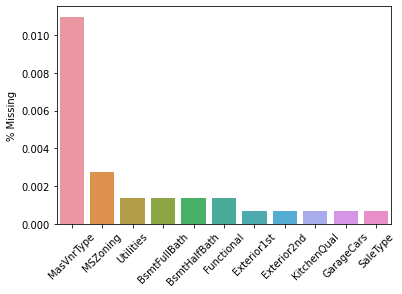

In [622]:
viz_missing(test)

In [623]:
test.loc[test.MasVnrType.isna(), ['MasVnrArea']]

,MasVnrArea
231,0.0000000000
246,0.0000000000
422,0.0000000000
532,0.0000000000
544,0.0000000000
581,0.0000000000
851,0.0000000000
865,0.0000000000
880,0.0000000000
889,0.0000000000


In [624]:
mode = test.MasVnrType.mode()[0]
test.loc[(test.MasVnrType.isna() & (test.MasVnrArea > 0)), 'MasVnrType'] = mode

In [625]:
test.loc[test.MasVnrType.isna(), ['MasVnrType']] = 'None'


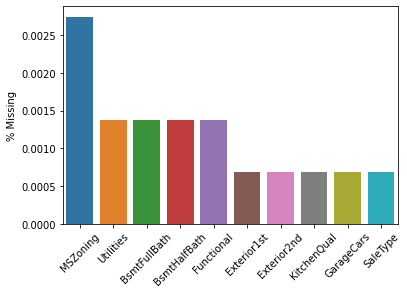

In [626]:
viz_missing(test)

In [627]:
test.loc[test.MSZoning.isna(), 'Neighborhood']

455      IDOTRR
756      IDOTRR
790      IDOTRR
1444    Mitchel
Name: Neighborhood, dtype: category
Categories (25, object): [Blmngtn, Blueste, BrDale, BrkSide, ..., Somerst, StoneBr, Timber, Veenker]

In [628]:
#What we are doing here is looking at which type of zoning particular neighborhoods have and 
#see if you can impute that for the null values in zoning from the neighborhoods that 
#are shared. 

In [629]:
test.loc[test.Neighborhood == 'IDOTRR', 'MSZoning'].value_counts()
#So all of the null neighborhoods are 'IDOTRR', so we will impute RM for MSZOning Null

RM         40
C (all)    13
RL          0
RH          0
FV          0
Name: MSZoning, dtype: int64

In [630]:
#We also need to check for Mitchel 
test.loc[test.Neighborhood == 'Mitchel', 'MSZoning'].value_counts()

RL         60
RM          4
RH          0
FV          0
C (all)     0
Name: MSZoning, dtype: int64

In [631]:
#We will impute RL for Mitchel 

mask1 = (test.Neighborhood == 'IDOTRR') & (test.MSZoning.isna())
mask2 = (test.Neighborhood == 'Mitchel') & (test.MSZoning.isna())
test.loc[mask1, 'MSZoning'] = 'RM'
test.loc[mask2, 'MSZoning'] = 'RL'


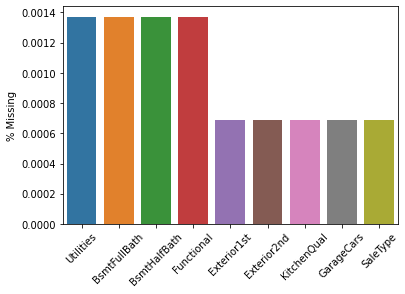

In [632]:
viz_missing(test)

Kind of a strange outlier that there is a home with high square footage, high quality that sold below avearge. 

In [633]:
rem_vars = ['Utilities', 'Functional', 'Exterior1st', 
        'Exterior2nd', 'KitchenQual', 'SaleType']

for var in rem_vars:
    mode = test[var].mode()[0]
    test.loc[test[var].isna(), var] = mode

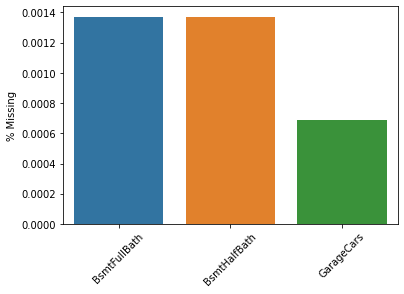

In [634]:
#So this means we still have BsmtFullBath, BsmtHalfBath, and GarageCars left to fix 
viz_missing(test)

In [635]:
test.loc[test.GarageCars.isna(), 'GarageArea']
##For GarageCars we have a garage that is 480 sq. ft. 

1116   480.0000000000
Name: GarageArea, dtype: float64

In [636]:
test.loc[test.GarageCars.isna(), 'GarageCars'] = 2

##we will assign this as a two car garage because that is a pretty big garage. 

In [637]:
bsmt_bths = ['BsmtFullBath', 'BsmtHalfBath']
mask = (test.BsmtFullBath.isna() | test.BsmtHalfBath.isna())
test.loc[mask, ['BsmtFinSF1']+bsmt_bths]

,BsmtFinSF1,BsmtFullBath,BsmtHalfBath
660,0.0000000000,nan,nan
728,0.0000000000,nan,nan


In [638]:
#Here we are checking if the basment has any finish where the bathroom in basement is null 

In [639]:
test.loc[mask, bsmt_bths] = test.loc[mask, bsmt_bths].fillna(0)

In [640]:
###Let's do some feature engineering and also look at feature importance. 

In [641]:
#Here we have total square foot which is a combination of all columns containing "sf"
SFTotals = data.filter(regex="SF")
data['totalsf'] = SFTotals.sum(axis=1)

#Test
SFTotals = test.filter(regex="SF")
test['totalsf'] = SFTotals.sum(axis=1)

In [642]:
#Here is a total quality, same as above.
QualTotal = data.filter(regex="Qual")
data["qualtotal"] = QualTotal.sum(axis=1)

#Test
#Here is a total quality, same as above.
QualTotal = test.filter(regex="Qual")
test["qualtotal"] = QualTotal.sum(axis=1)

In [643]:
porch_area = ['OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch']

data['HasPorch'] = data.loc[:, porch_area] \
                            .sum(axis=1) \
                            .apply(lambda x: 1 if x > 0 else 0)

test['HasPorch'] = test.loc[:, porch_area] \
                            .sum(axis=1) \
                            .apply(lambda x: 1 if x > 0 else 0)

In [644]:
#These are just a few examples of feature engineering that you can perform. 

In [645]:
test.drop(['MiscFeature'], axis=1, inplace=True)
data.drop(['MiscFeature'], axis=1, inplace=True)

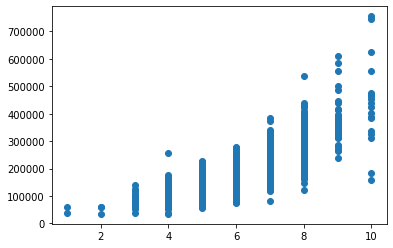

In [646]:
#That is where I will stop for the feature engineering, just going to check out a few more 
#visualizations. 
plt.scatter(data['OverallQual'], data['SalePrice'])
plt.show()

Distribution in categories would probably lead to high error rate with linear. 

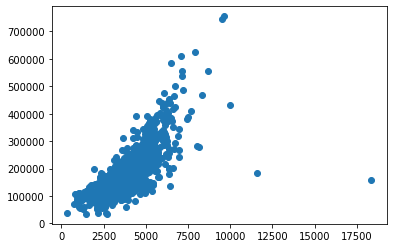

In [647]:
#let's look at total sf
plt.scatter(data['totalsf'], data['SalePrice'])
plt.show()

In [648]:
pd.set_option('display.float_format', lambda x: '%.10f' % x)

In [649]:
#Relatioships

#A few things to note, we have three variable types; 
#Continous
#Ordinal
#Nominal

##So what we are doing is segregating the variables by their type. 


exp_ordinal = ['ExterQual', 'BsmtQual', 'GarageQual', 
               'KitchenQual', 'FireplaceQu', 'PoolQC',  
               'OverallQual', 'ExterCond', 'BsmtCond', 
               'GarageCond', 'OverallCond', 'HeatingQC',
               'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 
               'GarageCars', 'GarageFinish', 'BedroomAbvGr', 
               'KitchenAbvGr', 'HouseStyle', 'TotRmsAbvGrd',
               'YearBuilt', 'MoSold', 'YrSold', 'MasVnrArea', 
               'Utilities', 'BsmtFullBath', 'BsmtHalfBath', 
               'FullBath', 'HalfBath', 'CentralAir', 
               'YearRemodAdd','LotShape', 'Functional', 'qualtotal']

exp_nominal = ['Neighborhood', 'MSZoning', 'Condition1', 
               'Condition2', 'RoofStyle', 
               'RoofMatl', 'Exterior1st', 'Exterior2nd', 
               'MasVnrType', 'Foundation', 'Electrical', 
               'SaleType', 'SaleCondition', 'HasShed',
               'HasTennis', 'HasGar2', 'HasPorch', 
               'HasDeck', 'HasPool', 'GarageType', 
               'LotConfig', 'PavedDrive', 'IsOld', 'IsNew']

exp_contin  = ['LotArea', 'LotFrontage', 'GrLivArea', 
               'GarageArea', 'BsmtFinSF1', 'BsmtFinSF2', 
               'TotalBsmtSF', 'BsmtUnfSF', '1stFlrSF', 
               '2ndFlrSF', 'LowQualFinSF', 'WoodDeckSF', 
               'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 
               'PoolArea', 'MiscVal', 'SalePrice', 'totalsf']


In [650]:
#Foruntaley, the schema for the quality conditions are the same across a large number of variables. 

#Ex = Excellent 
#Gd = Good 
#TA = Avearge/Typical 
#Fa = Fair 
#Po = Poor 

#We also have 'NA' which will we incude as 0, thus 0-5. 

In [651]:
qual_map = {'NA':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}
qual_vars = ['ExterQual', 'ExterCond', 'BsmtQual', 
             'BsmtCond', 'HeatingQC', 'KitchenQual', 
             'FireplaceQu', 'GarageQual', 'GarageCond',
             'PoolQC']

for col in qual_vars:
    data[col] = data[col].map(qual_map)
    test[col] = test[col].map(qual_map)
    
# Make sure we see all numeric data:    
data[qual_vars]

,ExterQual,ExterCond,BsmtQual,BsmtCond,HeatingQC,KitchenQual,FireplaceQu,GarageQual,GarageCond,PoolQC
0,4,3,4,3,5,4,0,3,3,0
1,3,3,4,3,5,3,3,3,3,0
2,4,3,4,3,5,4,3,3,3,0
3,3,3,3,4,4,4,4,3,3,0
4,4,3,4,3,5,4,3,3,3,0
...,...,...,...,...,...,...,...,...,...,...
1455,3,3,4,3,5,3,3,3,3,0
1456,3,3,4,3,3,3,3,3,3,0
1457,5,4,3,4,5,4,4,3,3,0
1458,3,3,3,3,4,4,0,3,3,0


In [652]:
#There are some quality variables that do not have the same unique quantities. 

BsmtExposure_map = {
    'Gd':4,
    'Av':3,
    'Mn':2,
    'No':1,
    'NA':0
}

BsmtFinType1_map = {
    'NA': 0,
    'Unf': 1,
    'LwQ': 2,
    'Rec': 3,
    'BLQ': 4,
    'ALQ': 5,
    'GLQ': 6
}

BsmtFinType2_map = {
    'NA': 0,
    'Unf': 1,
    'LwQ': 2,
    'Rec': 3,
    'BLQ': 4,
    'ALQ': 5,
    'GLQ': 6
}

GarageFinish_map = {
    'NA': 0,
    'Unf': 1,
    'RFn': 2,
    'Fin': 3
}

Functional_map = {
    'Sal': 0,
    'Sev': 1,
    'Maj2': 3,
    'Maj1': 4,
    'Mod': 5,
    'Min2': 6,
    'Min1': 7,
    'Typ': 8
}

Utilities_map = {
    'ELO': 0,
    'NoSeWa': 1,
    'NoSewr': 2,
    'AllPub': 3
}

CentralAir_map = {
    'N': 0,
    'Y': 1
}

LotShape_map = {
    'IR3': 0,
    'IR2': 1,
    'IR1': 2,
    'Reg': 3
}

HouseStyle_map = {
    '1Story': 1,
    '1.5Unf': 2,
    '1.5Fin': 3,
    '2Story': 4,
    '2.5Unf': 5,
    '2.5Fin': 6,
    'SFoyer': 7,
    'SLvl': 8
}

In [653]:
data.BsmtExposure = data.BsmtExposure.map(BsmtExposure_map)
data.BsmtFinType1 = data.BsmtFinType1.map(BsmtFinType1_map)
data.BsmtFinType2 = data.BsmtFinType2.map(BsmtFinType2_map)     
data.GarageFinish = data.GarageFinish.map(GarageFinish_map)
data.Functional   = data.Functional.map(Functional_map)
data.Utilities    = data.Utilities.map(Utilities_map)
data.CentralAir   = data.CentralAir.map(CentralAir_map)
data.LotShape     = data.LotShape.map(LotShape_map)
data.HouseStyle   = data.HouseStyle.map(HouseStyle_map)

test.BsmtExposure = test.BsmtExposure.map(BsmtExposure_map)
test.BsmtFinType1 = test.BsmtFinType1.map(BsmtFinType1_map)
test.BsmtFinType2 = test.BsmtFinType2.map(BsmtFinType2_map)     
test.GarageFinish = test.GarageFinish.map(GarageFinish_map)
test.Functional   = test.Functional.map(Functional_map)
test.Utilities    = test.Utilities.map(Utilities_map)
test.CentralAir   = test.CentralAir.map(CentralAir_map)
test.LotShape     = test.LotShape.map(LotShape_map)
test.HouseStyle   = test.HouseStyle.map(HouseStyle_map)

In [654]:
data.BsmtExposure

0       1
1       4
2       2
3       1
4       3
       ..
1455    1
1456    1
1457    1
1458    2
1459    1
Name: BsmtExposure, Length: 1460, dtype: category
Categories (5, int64): [3, 4, 2, 1, 0]

In [715]:
#Of course we have to consider the relationships with our predictor variables and 
#response variable. 

#We can look at correlation. 
data[ord1] = data[ord1].apply(pd.to_numeric)

#was having a problem with correlaiton, so just helping it out here. Turning categorical 
#variables to numeric. 

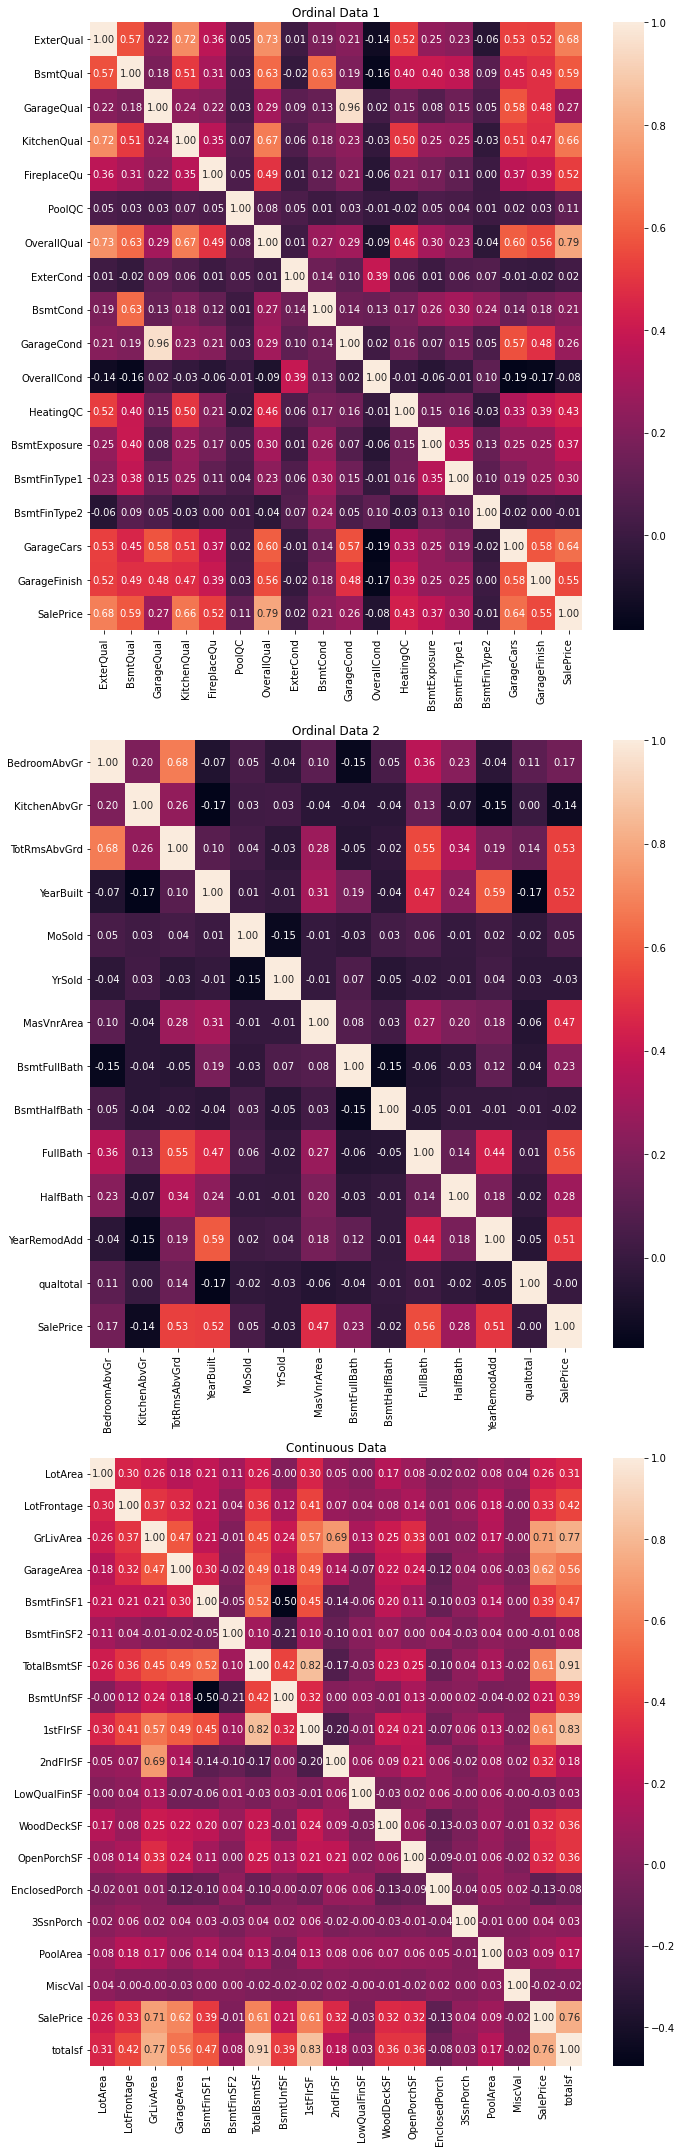

In [716]:
fig, axes = plt.subplots(3, 1, figsize=(10,30))


ord1 = exp_ordinal[:17] + ['SalePrice']
ord2 = exp_ordinal[17:] + ['SalePrice']

corr0 = data[ord1].corr(method='pearson')
corr2 = data[ord2].corr(method='pearson')

sns.heatmap(corr0, annot=True, ax=axes[0], fmt='0.2f').set_title('Ordinal Data 1')
sns.heatmap(corr2, annot=True, ax=axes[1], fmt='0.2f').set_title('Ordinal Data 2')
sns.heatmap(corr3, annot=True, ax=axes[2], fmt='0.2f').set_title('Continuous Data')

plt.tight_layout()
plt.show()

In [690]:
#There is a problem with the first corrplot that I will have to look into. 

#But, we see high correlation between a lot of the variables which is something we need to consider. 

              OverallQual   OverallCond    GarageCars     SalePrice
OverallQual  1.0000000000 -0.1525134724  0.5431204983  0.6696596603
OverallCond -0.1525134724  1.0000000000 -0.2268093894 -0.1034923995
GarageCars   0.5431204983 -0.2268093894  1.0000000000  0.5721678404
SalePrice    0.6696596603 -0.1034923995  0.5721678404  1.0000000000


In [719]:
ord1_corr = pd.DataFrame(
    data[ord1].corr(method='kendall').loc['SalePrice']
)

ord1_corr.sort_values(by='SalePrice', inplace=True, ascending=False)


ord2_corr = pd.DataFrame(
    data[ord2].corr(method='kendall').loc['SalePrice']
)
ord2_corr.sort_values(by='SalePrice', inplace=True, ascending=False)

cont_corr = pd.DataFrame(
    data[exp_contin].corr().loc['SalePrice']
)
cont_corr.sort_values(by='SalePrice', inplace=True, ascending=False)

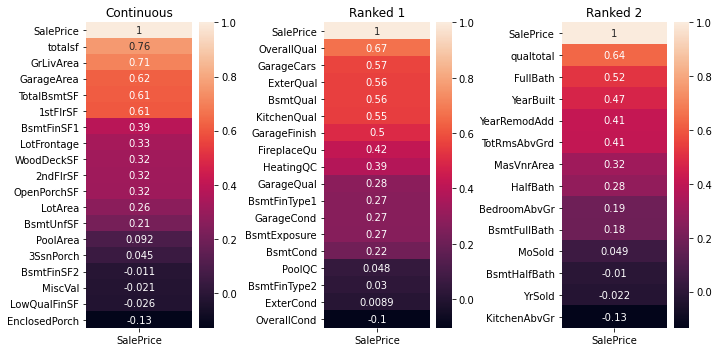

In [720]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(10, 5))
sns.heatmap(cont_corr, annot=True, ax=ax1).set_title('Continuous')
sns.heatmap(ord1_corr, annot=True, ax=ax2).set_title('Ranked 1')
sns.heatmap(ord2_corr, annot=True, ax=ax3).set_title('Ranked 2')
plt.tight_layout()
plt.show()

In [ ]:
#Coming back to this I will probably look at some more feature engineering opportunities. 

In [ ]:
#One thing to note is that corrrelation, in this case pearson is only for linear relaitonships and
#is somewhat niave. 

#Spearman correlation will probably best in this kind of sitatuion. 

In [ ]:
x = data.iloc[:, 1:80]
y = data.iloc[:, 80]

In [62]:
cols = list(x.columns)
pmax = 1
while (len(cols) > 0):
    p = []
    X_1 = x[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(y, X_1).fit()
    p = pd.Series(model.pvalues.values[1:], index = cols)
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.05):
        cols.remove(feature_with_p_max)
    else:
        break

In [17]:
selected_features_be = cols
print(p.sort_values(ascending =True))

PoolQC          0.0000000000
PoolArea        0.0000000000
OverallQual     0.0000000000
OverallCond     0.0000000000
GarageCars      0.0000000000
ExterQual       0.0000000004
YearBuilt       0.0000000005
2ndFlrSF        0.0000000026
BsmtQual        0.0000000060
MSSubClass      0.0000000345
KitchenQual     0.0000000709
LotArea         0.0000012216
SaleCondition   0.0000023354
KitchenAbvGr    0.0000040667
BsmtFinSF1      0.0000045231
TotalBsmtSF     0.0000053202
TotRmsAbvGrd    0.0000107841
Functional      0.0000145967
1stFlrSF        0.0000887094
GrLivArea       0.0001026885
Fireplaces      0.0001468930
ScreenPorch     0.0002525045
BsmtExposure    0.0003304172
BedroomAbvGr    0.0004427482
GarageYrBlt     0.0005443591
RoofMatl        0.0007342191
WoodDeckSF      0.0008565197
Neighborhood    0.0015483361
Street          0.0021408158
BsmtCond        0.0033615080
Condition2      0.0036480715
BsmtFullBath    0.0129622027
LowQualFinSF    0.0168176002
FireplaceQu     0.0314123349
dtype: float64

In [18]:
##Quite a few columns that have signifigance.
##Let's see if we can do some dimensionality reduction.
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

In [19]:
clf = RandomForestClassifier(n_estimators = 1000, random_state=0, n_jobs=-1)

In [20]:
clf.fit(x,y)
##Looking at gini purity

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=-1, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [21]:
feat_labels = list(data.iloc[:,0:80])
clf_features = pd.DataFrame(clf.feature_importances_)
feat_labels = pd.DataFrame(feat_labels)
merged_df = [feat_labels, clf_features]
result = pd.concat(merged_df, axis = 1)
result.columns = ['feat', 'importance']
result_1 = result.sort_values(by = 'importance')

In [22]:
results_2 = result_1.head(15)

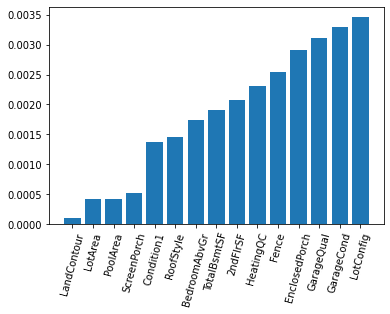

In [23]:
plt.bar(results_2['feat'], results_2['importance'])
plt.xticks(rotation=75)
plt.show()

This shows us gini purity, but might not be extremely helpful.
Because we are doing tree based, there is not a huge point for doing dimensionality reduction

In [24]:
data.to_csv(r'/Users/milesklingenberg/Documents/UWMSBA/590/Data/cleaned_data.csv', index=False)